# Sequitur and graph metrics for speech

### metrics
- number of nodes
- number of edges
- predictability / entropy of adjacency matrix
- sequitur
- In general, a network is considered “complex” if it exhibits many features such as small diameter, high clustering coefficient, anticorrelation of node degrees, presence of network motifs, and modularity structures [8].
    - - https://www.hindawi.com/journals/complexity/2017/3250301/

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from childes_mi.utils.paths import PHONBANK_DFS, DATA_DIR, FIGURE_DIR
from childes_mi.utils.general import flatten

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/tqdm/autonotebook.py:17: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [4]:
phone_df = pd.read_pickle(PHONBANK_DFS/'phone_df.pickle')

In [5]:
phone_df['n_phones'] = [len(list(flatten(i))) for i in phone_df.phones.values]

In [6]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [7]:
phone_df.dataset.unique()

array(['Providence', 'Davis', 'Goad'], dtype=object)

In [8]:
print("There are {} phones in this dataset".format(np.sum(phone_df.n_phones)))

There are 618583 phones in this dataset


In [9]:
import seaborn as sns
from childes_mi.utils.general import flatten,save_fig

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Compute graph
- for each sequence, calculate the decay of a sequence as a function of distance between elements for that sequence indiividually
- Treat each phoneme as unique for that child, and compute MI across children

#### Run MI by age cohort

In [10]:
phone_df[:3]

,name,transcript_id,age,dataset,language,sex,phones,orthography,xml_loc,n_phones
0,0,020926,2.833,Providence,eng,male,"[[ˈhi, ˈhæ, rəs], [ˈhi, ˈhæ, rəs], [ˈkævəʔ, ˈp...","[[[can, I], have, this], [[can, I], have, this...",/mnt/cube/tsainbur/Projects/github_repos/child...,1772
0,0,030006,3.000,Providence,eng,male,"[[*, haʊ, ˈbaʊ, *, ɪ, ˈdeɪ, mætʃ], [deɪ, ˈmætʃ...","[[xxx, how, <a>bout, xxx, if, they, match], [t...",/mnt/cube/tsainbur/Projects/github_repos/child...,2277
0,0,011117,2.000,Providence,eng,male,"[[None], [None], [None], [hɪ, ˈmi], [ˈbu], [No...","[[xxx], [xxx], [xxx], [help, me], [bowl], [xxx...",/mnt/cube/tsainbur/Projects/github_repos/child...,561


In [11]:
phon_table = "https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/edit#gid=0"

In [12]:
import requests as rs
csv_url='https://docs.google.com/spreadsheets/d/1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4/export?format=csv&id=1dcbQLKhazUePZrdgMimxZk3lbgPfZ_1VK5npFB3YJp4&gid=0'
res=rs.get(url=csv_url)
open('phon_labels.csv', 'wb').write(res.content)

21000

In [13]:
phon_labels = pd.read_csv("phon_labels.csv")

In [14]:
phon_labels[:3]

,Glyph,Unicode Value,Name,Type,Features
0,∅,0x2205,Empty Set,cover symbol,NaN
1,NaN,0x20,Space,space,NaN
2,$,0x24,Dollar Sign,dollar sign,NaN


In [15]:
age_cohorts = [[0.5, 1], [1, 1.5], [1.5, 2], [2, 2.5], [2.5, 3], [3, 20]]

In [16]:
import copy

In [17]:
import pymde
import networkx as nx
import numpy as np
import scipy.sparse as sp
import torch
from sksequitur import Parser, Grammar
from itertools import accumulate

In [18]:
def flatten(list_of_lists):
    if len(list_of_lists) == 0:
        return list_of_lists
    if isinstance(list_of_lists[0], list):
        return flatten(list_of_lists[0]) + flatten(list_of_lists[1:])
    return list_of_lists[:1] + flatten(list_of_lists[1:])

In [19]:
import scipy

In [162]:
def make_trans_mat(utterances, n_unique_phones, unique_phones_dict):
    # create transition matrix
    trans_mat = np.zeros((n_unique_phones, n_unique_phones))
    for utterance in utterances:
        for phone_prev, phone_next in zip(
            list(utterance[:-1]), list(utterance[1:])
        ):
            trans_mat[
                unique_phones_dict[phone_prev], unique_phones_dict[phone_next]
            ] += 1
    trans_mat_no_self = copy.deepcopy(trans_mat)
    for i in range(trans_mat.shape[1]):
        trans_mat_no_self[i, i] = 0
    return trans_mat, trans_mat_no_self

In [163]:
from pomegranate import DiscreteDistribution, State, HiddenMarkovModel
def utterances_to_markov_model(utterances):
    unique_phones = np.unique([item for sublist in utterances for item in sublist])
    unique_phones_dict = {j:i+2 for i,j in enumerate(unique_phones)}
    trans_mat = np.zeros((len(unique_phones)+2, len(unique_phones)+2))
    for utterance in utterances:
        trans_mat[0, unique_phones_dict[utterance[0]]] += 1
        trans_mat[unique_phones_dict[utterance[-1]], 1] += 1
        for outgoing, incoming in zip(utterance[:-1], utterance[1:]):
            trans_mat[unique_phones_dict[outgoing], unique_phones_dict[incoming]] += 1

    trans_mat_prob = np.nan_to_num(trans_mat.T / np.sum(trans_mat, axis = 1)).T
    dists = [DiscreteDistribution({unique_phones[i]:1.0}) for i in range(len(trans_mat_prob)-2)]
    starts = trans_mat_prob[0, 2:]
    ends = trans_mat_prob[2:,1]
    trans_mat = trans_mat_prob[2:,2:]
    model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends)
    return model


In [164]:
import itertools

unique_phones_all = np.unique(
    np.concatenate(
        [
            np.unique(
                list(
                    "".join(
                        [
                            i
                            for i in list(itertools.chain.from_iterable(i))
                            if type(i) is str
                        ]
                    )
                )
            )
            for i in phone_df.phones.values
        ]
    )
)
print(unique_phones_all, len(unique_phones_all))

['(' ')' '*' '.' 'C' 'G' 'V' '^' 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j'
 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u' 'v' 'w' 'x' 'y' 'z' 'æ' 'ç'
 'ð' 'ø' 'ŋ' 'œ' 'ǁ' 'ɐ' 'ɑ' 'ɒ' 'ɔ' 'ɕ' 'ɖ' 'ə' 'ɚ' 'ɛ' 'ɜ' 'ɟ' 'ɡ' 'ɢ'
 'ɣ' 'ɥ' 'ɦ' 'ɨ' 'ɪ' 'ɫ' 'ɬ' 'ɭ' 'ɮ' 'ɯ' 'ɰ' 'ɱ' 'ɲ' 'ɳ' 'ɵ' 'ɶ' 'ɸ' 'ɹ'
 'ɻ' 'ɽ' 'ɾ' 'ʀ' 'ʁ' 'ʂ' 'ʃ' 'ʈ' 'ʉ' 'ʊ' 'ʋ' 'ʌ' 'ʍ' 'ʎ' 'ʏ' 'ʑ' 'ʒ' 'ʔ'
 'ʙ' 'ʝ' 'ʤ' 'ʦ' 'ʧ' 'ʰ' 'ʲ' 'ʴ' 'ʷ' 'ˈ' 'ˌ' 'ː' 'ˑ' '˞' 'ˠ' '˺' '́' '̂'
 '̃' '̆' '̈' '̑' '̚' '̞' '̠' '̣' '̤' '̥' '̩' '̪' '̬' '̰' '̵' '̹' '͆' '͍'
 '͡' 'β' 'θ' 'χ'] 130


In [165]:
import seaborn as sns
# get color categories
pal = {i: j for i, j in zip(phon_labels.Type.unique(), sns.color_palette("tab10", len(phon_labels.Type.unique())))}
unique_phones_color_dict = {}
for i in unique_phones_all:
    if i in phon_labels.Glyph.values:
        _type = phon_labels[phon_labels.Glyph.values == i].Type.values[0]
        unique_phones_color_dict[i] = pal[_type]
    else:
        unique_phones_color_dict[i] = (0.5,0.5,0.5)

In [247]:
def plot_graph(trans_mat, unique_phones):
    fig, ax = plt.subplots(figsize=(10,10))
    G = nx.from_numpy_matrix(trans_mat, create_using=nx.MultiDiGraph)
    pos = nx.drawing.nx_agraph.pygraphviz_layout(G)

    node_sizes = [800 for i in range(len(G))]
    M = G.number_of_edges()
    #edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
    edge_alphas = [edge[2]['weight'] for edge in G.edges(data=True)]
    node_colors = [unique_phones_color_dict[i] for i in unique_phones]
    nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
    edges = nx.draw_networkx_edges(
        G,
        pos,
        node_size=node_sizes,
        arrowstyle="-|>",
        arrowsize=10,
        edge_color='k',
        edge_cmap=plt.cm.Greys,
        width=2,

    )
    # set alpha value for each edge
    for i in range(M):
        edges[i].set_alpha(edge_alphas[i])

    #pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    #pc.set_array(edge_colors)
    #plt.colorbar(pc)

    for posi, label_pos in enumerate(pos):
        ax.text(
            x=pos[label_pos][0],
            y=pos[label_pos][1],
            s=unique_phones[posi],
            horizontalalignment="center",
            verticalalignment="center",
            color='white',
            fontsize=15
        )

    ax = plt.gca()
    ax.set_axis_off()
    plt.show()

In [167]:
from sksequitur import Parser, Grammar
def get_sequitur_compression(utterances):
    # sequitur compression
    parser = Parser()
    for i in utterances:
        parser.feed(list(i))
    grammer = Grammar(parser.tree)
    sequitur_compression_length = len(grammer[0])
    sequitur_compression = len(utterances)  / sequitur_compression_length
    return sequitur_compression

In [256]:
from scipy import stats
def compute_mean_transition_entropy(utterances):
    all_phones = [item for sublist in utterances for item in sublist]
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}

    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))

    return np.mean(
    [
        stats.entropy(i)
        for i in trans_mat_prob.T
        if np.isnan(stats.entropy(i)) == False
    ]
    )

In [257]:
def get_metrics(utterances):
    # number of phones and unique_phones
    all_phones = [item for sublist in utterances for item in sublist]
    n_phones = len(all_phones)
    unique_phones = np.unique(all_phones)
    n_unique_phones = len(unique_phones)
    unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}

    # make transition matrix
    trans_mat, trans_mat_no_self = make_trans_mat(
        utterances, n_unique_phones, unique_phones_dict
    )
    trans_mat_prob = np.nan_to_num((trans_mat / np.sum(trans_mat, axis=0)))

    # create a graph and get graph-based statistics
    G = nx.from_numpy_matrix(trans_mat_prob)
    try:
        diameter = nx.algorithms.distance_measures.diameter(G)
    except:
        diameter = np.nan
    clustering_coefficient = nx.average_clustering(G)

    sequitur_compression = get_sequitur_compression(utterances)

    # transition entropy
    mean_transition_entropy = np.mean(
        [
            scipy.stats.entropy(i)
            for i in trans_mat_prob.T
            if np.isnan(scipy.stats.entropy(i)) == False
        ]
    )

    return pd.DataFrame(
        [[
            n_unique_phones,
            n_phones,
            diameter,
            clustering_coefficient,
            sequitur_compression,
            mean_transition_entropy,
        ]],
        columns=[
            "n_unique_phones",
            "n_phones",
            "diameter",
            "clustering_coefficient",
            "sequitur_compression",
            "mean_transition_entropy",
        ],
    ), unique_phones, trans_mat_prob

In [258]:
from joblib import Parallel, delayed
def get_markov_compression(utterances):
    # markov model
    model = utterances_to_markov_model(utterances)
    markov_utterances = model.sample(len(utterances))
    return get_sequitur_compression(markov_utterances), compute_mean_transition_entropy(markov_utterances)

def get_random_compression(utterances):
    # markov model
    # make randomized utterance
    utterance_lengths = [len(i) for i in utterances]
    utterance_list = np.random.permutation(list("".join(utterances)))
    permuted_utterance = [
        "".join(utterance_list[x - y : x])
        for x, y in zip(accumulate(utterance_lengths), utterance_lengths)
    ]
    return get_sequitur_compression(permuted_utterance), compute_mean_transition_entropy(permuted_utterance)

0.5 1


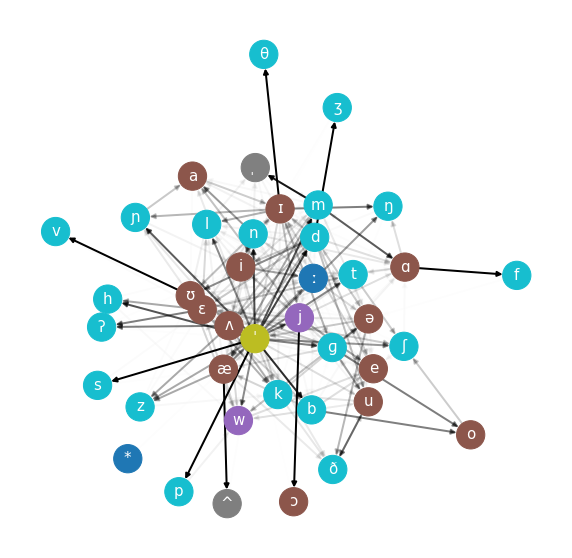

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


1 1.5


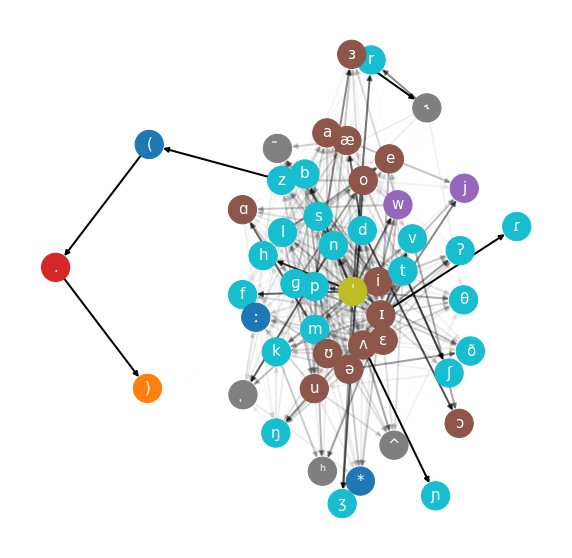

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


1.5 2


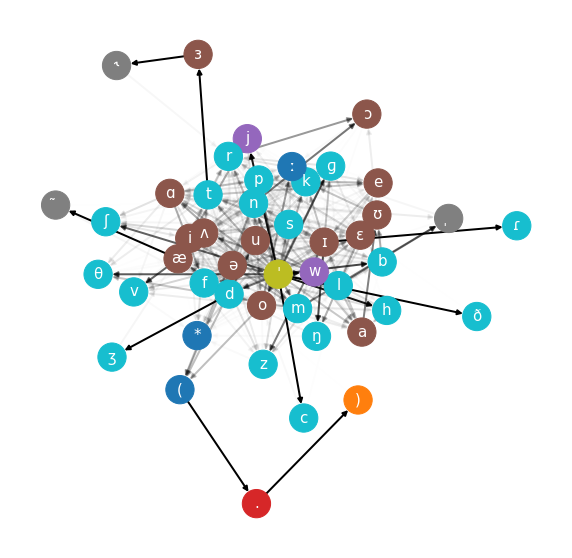

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


2 2.5


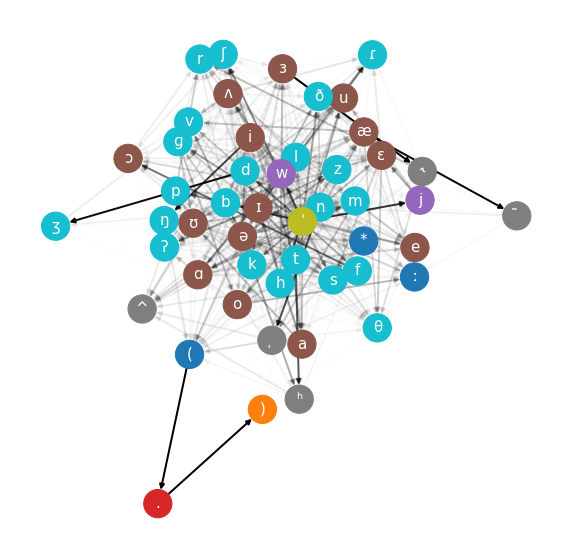

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


2.5 3


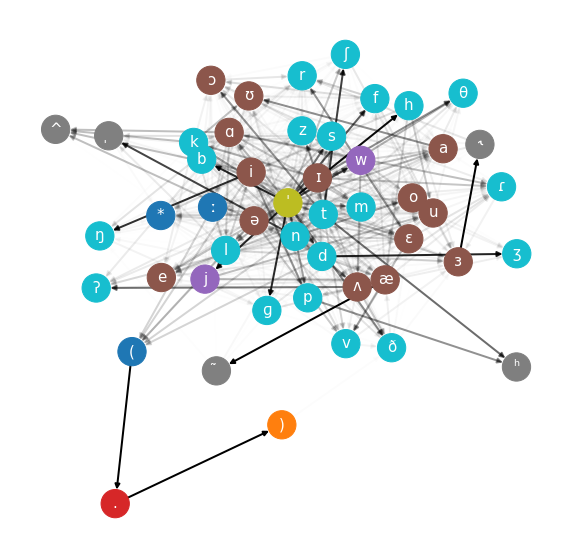

3 20


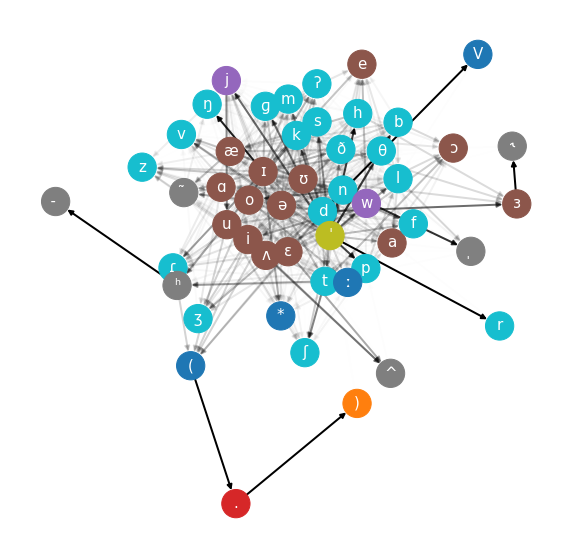

/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2751: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


In [280]:
metrics_dfs = []

nex = 25
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(
        cohort_subset.sort_values(by="n_phones", ascending=False)[:nex].reset_index().iterrows(),
        total=nex, leave=False
    ):
        words_utterances_phones = [
            flatten(i) for i in longest_row.phones if i[0] is not None
        ]
        words_utterances_phones = [
            [j for j in i if j is not None] for i in words_utterances_phones
        ]

        utterances = ["".join(i) for i in words_utterances_phones]
        
        metrics_df_row, unique_phones, trans_mat = get_metrics(utterances)
        metrics_df_row['age_cohort_low'] = age_cohort_low
        metrics_df_row['age_cohort_high'] = age_cohort_high
        
        # add compression info
        markov_compression_markov_entropy = Parallel(n_jobs = -1)(delayed(get_markov_compression)(utterances) for i in tqdm(range(1000), leave=False))
        markov_compression = [i[0] for i in markov_compression_markov_entropy]
        markov_entropy = [i[1] for i in markov_compression_markov_entropy]
        random_compression_random_entropy = Parallel(n_jobs = -1)(delayed(get_random_compression)(utterances) for i in tqdm(range(1000), leave=False))
        random_compression = [i[0] for i in random_compression_random_entropy]
        random_entropy = [i[1] for i in random_compression_random_entropy]
        compression_df = pd.DataFrame(columns=['markov_compression', 'random_compression', 'markov_entropy', 'random_entropy'])
        for col in compression_df.columns:
            compression_df[col] = compression_df[col].astype(object)
        compression_df.loc[0, 'random_compression'] = np.array(random_compression)
        compression_df.loc[0, 'markov_compression'] = np.array(markov_compression)
        compression_df.loc[0, 'random_entropy'] = np.array(random_entropy)
        compression_df.loc[0, 'markov_entropy'] = np.array(markov_entropy)
        
        metrics_df_row = pd.concat([metrics_df_row, compression_df], axis=1)
        
        # append
        metrics_dfs.append(metrics_df_row)
        
        if idx == 0:
            plot_graph(trans_mat, unique_phones)
        

In [281]:
metrics_df = pd.concat(metrics_dfs)

In [282]:
metrics_df.to_pickle(DATA_DIR / 'sequitur_metrics.pickle')

In [245]:
breakme

((41, 41), 41)

In [ ]:
# graph coordinates can be based on similarity of connections, rather than trying to pull toward connections (e.g. from probabilty matrix)

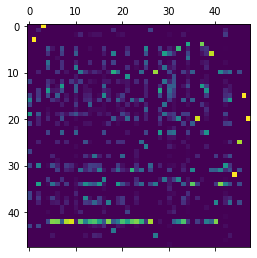

In [267]:
plt.matshow(np.log(trans_mat+1e-1))

In [268]:
from umap import UMAP

In [272]:
len(z)

48

In [270]:
z = UMAP(verbose=True).fit_transform(trans_mat)

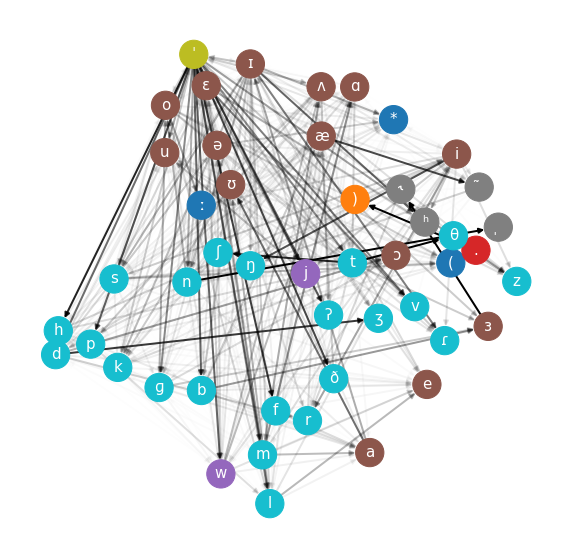

In [279]:
fig, ax = plt.subplots(figsize=(10,10))
G = nx.from_numpy_matrix(trans_mat, create_using=nx.MultiDiGraph)
#pos = nx.drawing.nx_agraph.pygraphviz_layout(G)
pos = {i:tuple(j) for i,j in enumerate(z)}

node_sizes = [800 for i in range(len(G))]
M = G.number_of_edges()
#edge_alphas = [(5 + i) / (M + 4) for i in range(M)]
edge_alphas = [edge[2]['weight'] for edge in G.edges(data=True)]
node_colors = [unique_phones_color_dict[i] for i in unique_phones]
nodes = nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors)
edges = nx.draw_networkx_edges(
    G,
    pos,
    node_size=node_sizes,
    arrowstyle="-|>",
    arrowsize=10,
    edge_color='k',
    edge_cmap=plt.cm.Greys,
    width=2,

)
# set alpha value for each edge
for i in range(M):
    edges[i].set_alpha(edge_alphas[i])

#pc = mpl.collections.PatchCollection(edges, cmap=plt.cm.Blues)
#pc.set_array(edge_colors)
#plt.colorbar(pc)

for posi, label_pos in enumerate(pos):
    ax.text(
        x=pos[label_pos][0],
        y=pos[label_pos][1],
        s=unique_phones[posi],
        horizontalalignment="center",
        verticalalignment="center",
        color='white',
        fontsize=15
    )

ax = plt.gca()
ax.set_axis_off()
plt.show()

In [171]:
metrics_df = pd.DataFrame(
    columns=[
        "age_cohort_low",
        "age_cohort_high",
        "n_phones",
        "n_unique_phones",
        "sequitur_compression_length",
        "len_utterances",
        "sequitur_compression_length_permuted",
        "sequitur_compression_length_markov",
        "mean_transition_entropy",
        "mean_transition_entropy_random",
        "mean_transition_entropy_markov",
        "diameter",
        "diameter_random",
        "diameter_markov",
        "clustering_coefficient",
        "clustering_coefficient_random",
        "clustering_coefficient_markov",
    ]
)
nex = 25
# for each age cohort
for (age_cohort_low, age_cohort_high) in tqdm(age_cohorts):
    cohort_subset = phone_df[
        (phone_df.age > age_cohort_low) & (phone_df.age <= age_cohort_high)
    ]
    print(age_cohort_low, age_cohort_high)
    for idx, longest_row in tqdm(
        cohort_subset.sort_values(by="n_phones", ascending=False)[:nex].reset_index().iterrows(),
        total=nex,
    ):
        words_utterances_phones = [
            flatten(i) for i in longest_row.phones if i[0] is not None
        ]
        words_utterances_phones = [
            [j for j in i if j is not None] for i in words_utterances_phones
        ]
        phones = "".join((flatten(words_utterances_phones)))
        n_phones = len(phones)
        unique_phones = np.unique(list(phones))
        unique_phones_dict = {i: ii for ii, i in enumerate(unique_phones)}
        n_unique_phones = len(np.unique(list(phones)))

        utterances = ["".join(i) for i in words_utterances_phones]
        # make randomized utterance
        utterance_lengths = [len(i) for i in utterances]
        utterance_list = np.random.permutation(list("".join(utterances)))
        permuted_utterance = [
            "".join(utterance_list[x - y : x])
            for x, y in zip(accumulate(utterance_lengths), utterance_lengths)
        ]
        # markov model
        model = utterances_to_markov_model(utterances)
        markov_utterances = model.sample(len(utterance_lengths))

        # create transition matrix
        trans_mat, trans_mat_no_self = make_trans_mat(utterances, n_unique_phones)
        # create transition matrix random
        trans_mat_random, trans_mat_no_self_random = make_trans_mat(
            permuted_utterance, n_unique_phones
        )
        # create transition matrix random
        trans_mat_markov, trans_mat_no_self_markov = make_trans_mat(
            markov_utterances, n_unique_phones
        )
        
        trans_mat_prob = np.nan_to_num((
                    trans_mat / np.sum(trans_mat, axis=0)
                ))
    
        trans_mat_prob_random = np.nan_to_num((
                    trans_mat_random / np.sum(trans_mat_random, axis=0)
                ))
        trans_mat_prob_markov = np.nan_to_num((
                    trans_mat_markov / np.sum(trans_mat_markov, axis=0)
                ))

        G = nx.from_numpy_matrix(trans_mat_prob)
        try:
            diameter = nx.algorithms.distance_measures.diameter(G)
        except:
            diameter = np.nan
        clustering_coefficient = nx.average_clustering(G)

        G_random = nx.from_numpy_matrix(trans_mat_prob_random)
        try:
            diameter_random = nx.algorithms.distance_measures.diameter(G_random)
        except:
            diamter_random = np.nan
        clustering_coefficient_random = nx.average_clustering(G_random)
        
        G_markov = nx.from_numpy_matrix(trans_mat_prob_markov)
        try:
            diameter_markov = nx.algorithms.distance_measures.diameter(G_markov)
        except:
            diameter_markov = np.nan
        clustering_coefficient_markov = nx.average_clustering(G_markov)

        if idx == 0:
            plot_graph(trans_mat, unique_phones)

        # sequitur compression
        parser = Parser()
        for i in utterances:
            parser.feed(list(i))
        grammer = Grammar(parser.tree)
        sequitur_compression_length = len(grammer[0])

        # sequitur compression randomized
        parser = Parser()
        for i in permuted_utterance:
            parser.feed(list(i))
        grammer = Grammar(parser.tree)
        sequitur_compression_length_permuted = len(grammer[0])
        
        # sequitur compression randomized
        parser = Parser()
        for i in markov_utterances:
            parser.feed(list(i))
        grammer = Grammar(parser.tree)
        sequitur_compression_length_markov = len(grammer[0])

        # transition entropy
        mean_transition_entropy = np.mean(
            [
                scipy.stats.entropy(i)
                for i in trans_mat_prob.T
                if np.isnan(scipy.stats.entropy(i)) == False
            ]
        )
        # transition entropy randomized
        mean_transition_entropy_random = np.mean(
            [
                scipy.stats.entropy(i)
                for i in trans_mat_prob_random.T
                if np.isnan(scipy.stats.entropy(i)) == False
            ]
        )
        
        mean_transition_entropy_markov = np.mean(
            [
                scipy.stats.entropy(i)
                for i in trans_mat_prob_markov.T
                if np.isnan(scipy.stats.entropy(i)) == False
            ]
        )

        metrics_df.loc[len(metrics_df)] = [
            age_cohort_low,
            age_cohort_high,
            n_phones,
            n_unique_phones,
            sequitur_compression_length,
            len("".join(utterances)),
            sequitur_compression_length_permuted,
            sequitur_compression_length_markov,
            mean_transition_entropy,
            mean_transition_entropy_random,
            mean_transition_entropy_markov,
            diameter,
            diameter_random,
            diameter_markov,
            clustering_coefficient,
            clustering_coefficient_random,
            clustering_coefficient_markov,
        ]

0.5 1


/home/AD/tsainbur/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


TypeError: make_trans_mat() missing 1 required positional argument: 'unique_phones_dict'

In [286]:
metrics_df['sequitur_compression'] = metrics_df.len_utterances  / metrics_df.sequitur_compression_length
metrics_df['sequitur_compression_random'] = metrics_df.len_utterances / metrics_df.sequitur_compression_length_permuted
metrics_df['sequitur_compression_markov'] = metrics_df.len_utterances / metrics_df.sequitur_compression_length_markov
metrics_df['sequitur_compression_relative_to_random'] = metrics_df.sequitur_compression / metrics_df.sequitur_compression_random 
metrics_df['sequitur_compression_relative_to_markov'] = metrics_df.sequitur_compression / metrics_df.sequitur_compression_markov
metrics_df['markov_sequitur_compression_relative_to_random'] = metrics_df.sequitur_compression_markov / metrics_df.sequitur_compression_random 
metrics_df['transition_entropy_relative_to_random'] = metrics_df.mean_transition_entropy  / metrics_df.mean_transition_entropy_random

AttributeError: 'DataFrame' object has no attribute 'len_utterances'

In [132]:
metrics_df[:3]

,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,sequitur_compression_length,len_utterances,sequitur_compression_length_permuted,sequitur_compression_length_markov,mean_transition_entropy,mean_transition_entropy_random,...,clustering_coefficient,clustering_coefficient_random,clustering_coefficient_markov,sequitur_compression,sequitur_compression_random,sequitur_compression_markov,sequitur_compression_relative_to_random,sequitur_compression_relative_to_markov,markov_sequitur_compression_relative_to_random,transition_entropy_relative_to_random
0,0.5,1.0,2643.0,41.0,896.0,2643.0,1420.0,1020.0,1.149222,1.977501,...,0.504382,0.786925,0.449217,2.949777,1.861268,2.591176,1.584821,1.138393,1.392157,0.581149
1,0.5,1.0,2280.0,40.0,845.0,2280.0,1234.0,908.0,1.509324,2.078039,...,0.495047,0.802175,0.468855,2.698225,1.847650,2.511013,1.460355,1.074556,1.359031,0.726321
2,0.5,1.0,627.0,28.0,313.0,627.0,348.0,334.0,0.829158,1.460676,...,0.400533,0.548593,0.316679,2.003195,1.801724,1.877246,1.111821,1.067093,1.041916,0.567654


In [133]:
import seaborn as sns

(0, 1.2)

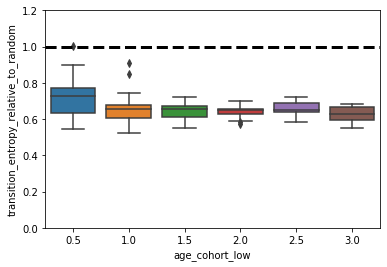

In [134]:
fig, ax = plt.subplots()
sns.boxplot(x = "age_cohort_low", y="transition_entropy_relative_to_random", data = metrics_df, ax=ax)
ax.axhline(1, lw=3, color='k', ls='dashed')
ax.set_ylim([0, 1.2])

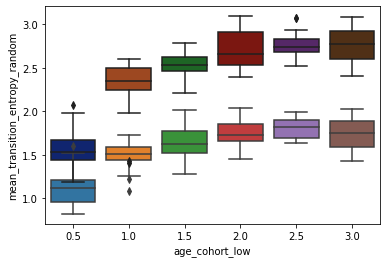

In [135]:
sns.boxplot(x = "age_cohort_low", y="mean_transition_entropy", data = metrics_df)
sns.boxplot(x = "age_cohort_low", y="mean_transition_entropy_random", data = metrics_df, palette='dark')

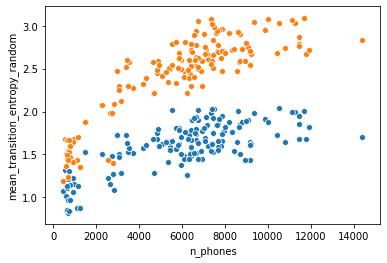

In [136]:
sns.scatterplot(x = "n_phones", y="mean_transition_entropy", data = metrics_df)
sns.scatterplot(x = "n_phones", y="mean_transition_entropy_random", data = metrics_df, palette='dark')

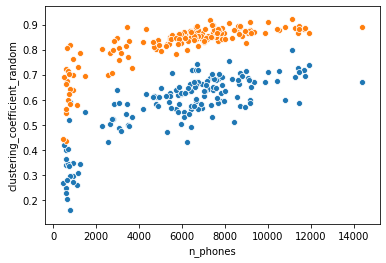

In [137]:
sns.scatterplot(x = "n_phones", y="clustering_coefficient", data = metrics_df)
sns.scatterplot(x = "n_phones", y="clustering_coefficient_random", data = metrics_df, palette='dark')

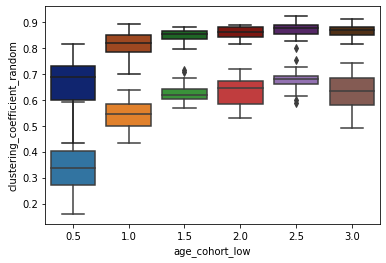

In [138]:
sns.boxplot(x = "age_cohort_low", y="clustering_coefficient", data = metrics_df)
sns.boxplot(x = "age_cohort_low", y="clustering_coefficient_random", data = metrics_df, palette='dark')

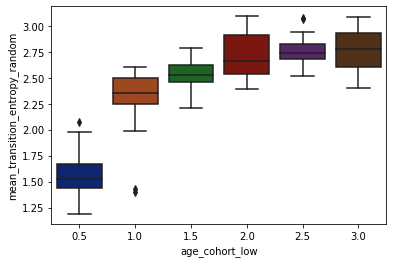

In [139]:
sns.boxplot(x = "age_cohort_low", y="mean_transition_entropy_random", data = metrics_df, palette='dark')

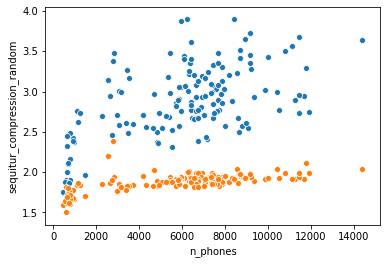

In [140]:
sns.scatterplot(x = "n_phones", y="sequitur_compression", data = metrics_df)
sns.scatterplot(x = "n_phones", y="sequitur_compression_random", data = metrics_df)

(0, 2.5)

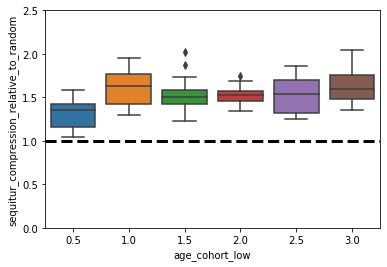

In [141]:
fig, ax = plt.subplots()
sns.boxplot(x = "age_cohort_low", y="sequitur_compression_relative_to_random", data = metrics_df, ax=ax)
ax.axhline(1, lw=3, color='k', ls='dashed')
ax.set_ylim([0, 2.5])

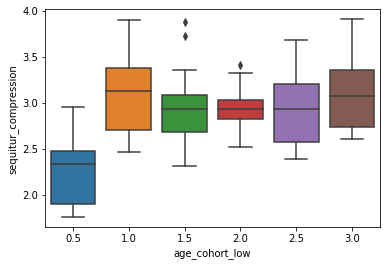

In [142]:
sns.boxplot(x = "age_cohort_low", y="sequitur_compression", data = metrics_df)

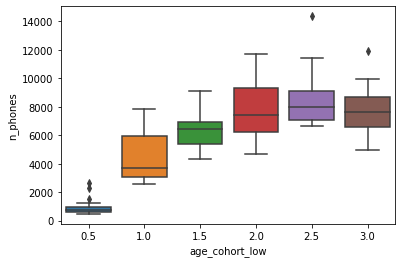

In [143]:
sns.boxplot(x = "age_cohort_low", y="n_phones", data = metrics_df)

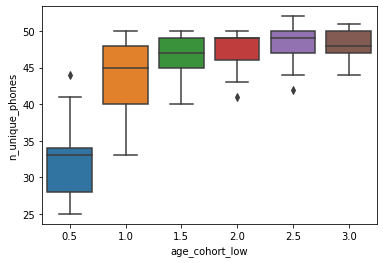

In [144]:
sns.boxplot(x = "age_cohort_low", y="n_unique_phones", data = metrics_df)

In [145]:
metrics_df[:3]

,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,sequitur_compression_length,len_utterances,sequitur_compression_length_permuted,sequitur_compression_length_markov,mean_transition_entropy,mean_transition_entropy_random,...,clustering_coefficient,clustering_coefficient_random,clustering_coefficient_markov,sequitur_compression,sequitur_compression_random,sequitur_compression_markov,sequitur_compression_relative_to_random,sequitur_compression_relative_to_markov,markov_sequitur_compression_relative_to_random,transition_entropy_relative_to_random
0,0.5,1.0,2643.0,41.0,896.0,2643.0,1420.0,1020.0,1.149222,1.977501,...,0.504382,0.786925,0.449217,2.949777,1.861268,2.591176,1.584821,1.138393,1.392157,0.581149
1,0.5,1.0,2280.0,40.0,845.0,2280.0,1234.0,908.0,1.509324,2.078039,...,0.495047,0.802175,0.468855,2.698225,1.847650,2.511013,1.460355,1.074556,1.359031,0.726321
2,0.5,1.0,627.0,28.0,313.0,627.0,348.0,334.0,0.829158,1.460676,...,0.400533,0.548593,0.316679,2.003195,1.801724,1.877246,1.111821,1.067093,1.041916,0.567654


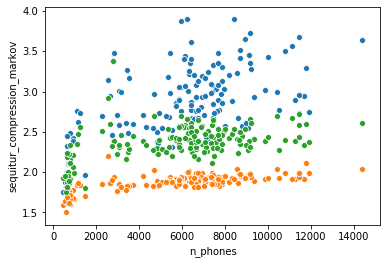

In [146]:
sns.scatterplot(x = "n_phones", y="sequitur_compression", data = metrics_df)
sns.scatterplot(x = "n_phones", y="sequitur_compression_random", data = metrics_df)
sns.scatterplot(x = "n_phones", y="sequitur_compression_markov", data = metrics_df)

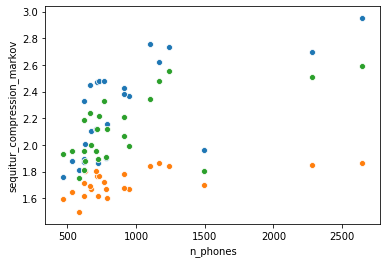

In [147]:
sns.scatterplot(x = "n_phones", y="sequitur_compression", data = metrics_df[metrics_df.age_cohort_low == 0.5])
sns.scatterplot(x = "n_phones", y="sequitur_compression_random", data = metrics_df[metrics_df.age_cohort_low == 0.5])
sns.scatterplot(x = "n_phones", y="sequitur_compression_markov", data = metrics_df[metrics_df.age_cohort_low == 0.5])

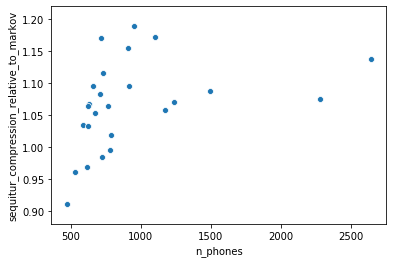

In [148]:
sns.scatterplot(x = "n_phones", y="sequitur_compression_relative_to_markov", data = metrics_df[metrics_df.age_cohort_low == 0.5])

In [285]:
metrics_df[:3]

,n_unique_phones,n_phones,diameter,clustering_coefficient,sequitur_compression,mean_transition_entropy,age_cohort_low,age_cohort_high,markov_compression,random_compression,markov_entropy,random_entropy
0,41,2643,3.0,0.504382,0.368304,1.149222,0.5,1.0,"[0.3316582914572864, 0.3113207547169811, 0.297...","[0.2320675105485232, 0.23554603854389722, 0.23...","[1.0878647689275116, 1.1780975191029102, 1.100...","[1.9521779247385465, 1.9599878923724965, 1.929..."
0,40,2280,3.0,0.495047,0.349112,1.509324,0.5,1.0,"[0.3333333333333333, 0.30412371134020616, 0.29...","[0.23543495610534718, 0.23867313915857605, 0.2...","[1.363163274708729, 1.4680432181718324, 1.3622...","[2.1111646022748496, 2.0315112176307264, 1.956..."
0,28,627,5.0,0.400533,1.038339,0.829158,0.5,1.0,"[1.0220125786163523, 1.0655737704918034, 0.996...","[0.9129213483146067, 0.9475218658892128, 0.936...","[0.6533836242825227, 0.7578058534543245, 0.754...","[1.1877991411513158, 1.280082640030571, 0.9685..."


In [284]:
sns.scatterplot(x = "n_phones", y="sequitur_compression_relative_to_markov", color = 'age_cohort_low', data = metrics_df)

ValueError: Could not interpret input 'sequitur_compression_relative_to_markov'

In [149]:
metrics_df[['age_cohort_low', 'sequitur_compression', 'sequitur_compression_markov']]

,age_cohort_low,sequitur_compression,sequitur_compression_markov
0,0.5,2.949777,2.591176
1,0.5,2.698225,2.511013
2,0.5,2.003195,1.877246
3,0.5,2.754386,2.348291
4,0.5,1.895706,1.955696
...,...,...,...
145,3.0,3.400106,2.502340
146,3.0,3.210449,2.449702
147,3.0,2.890486,2.409335
148,3.0,2.666667,2.386364


(0, 1.8)

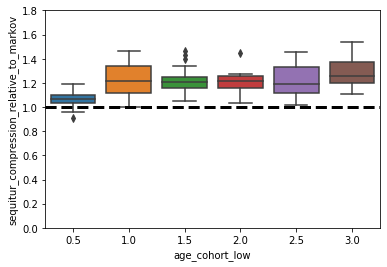

In [150]:
fig, ax = plt.subplots()
sns.boxplot(x = "age_cohort_low", y="sequitur_compression_relative_to_markov", data = metrics_df, ax=ax)
ax.axhline(1, lw=3, color='k', ls='dashed')
ax.set_ylim([0, 1.8])

In [151]:
from scipy import stats

In [152]:
stats.ttest_rel(metrics_df[metrics_df.age_cohort_low == 0.5]['sequitur_compression'], metrics_df[metrics_df.age_cohort_low == 0.5]['sequitur_compression_markov'])

Ttest_relResult(statistic=4.886454039395109, pvalue=5.544256790938954e-05)

In [153]:
metrics_df

,age_cohort_low,age_cohort_high,n_phones,n_unique_phones,sequitur_compression_length,len_utterances,sequitur_compression_length_permuted,sequitur_compression_length_markov,mean_transition_entropy,mean_transition_entropy_random,...,clustering_coefficient,clustering_coefficient_random,clustering_coefficient_markov,sequitur_compression,sequitur_compression_random,sequitur_compression_markov,sequitur_compression_relative_to_random,sequitur_compression_relative_to_markov,markov_sequitur_compression_relative_to_random,transition_entropy_relative_to_random
0,0.5,1.0,2643.0,41.0,896.0,2643.0,1420.0,1020.0,1.149222,1.977501,...,0.504382,0.786925,0.449217,2.949777,1.861268,2.591176,1.584821,1.138393,1.392157,0.581149
1,0.5,1.0,2280.0,40.0,845.0,2280.0,1234.0,908.0,1.509324,2.078039,...,0.495047,0.802175,0.468855,2.698225,1.847650,2.511013,1.460355,1.074556,1.359031,0.726321
2,0.5,1.0,627.0,28.0,313.0,627.0,348.0,334.0,0.829158,1.460676,...,0.400533,0.548593,0.316679,2.003195,1.801724,1.877246,1.111821,1.067093,1.041916,0.567654
3,0.5,1.0,1099.0,34.0,399.0,1099.0,597.0,468.0,0.876708,1.438855,...,0.258653,0.579657,0.214971,2.754386,1.840871,2.348291,1.496241,1.172932,1.275641,0.609309
4,0.5,1.0,618.0,29.0,326.0,618.0,341.0,316.0,1.018745,1.361198,...,0.248108,0.434565,0.176850,1.895706,1.812317,1.955696,1.046012,0.969325,1.079114,0.748418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,3.0,20.0,6416.0,46.0,1887.0,6416.0,3415.0,2564.0,1.588415,2.786761,...,0.492183,0.871622,0.446139,3.400106,1.878770,2.502340,1.809751,1.358771,1.331903,0.569986
146,3.0,20.0,6575.0,49.0,2048.0,6575.0,3415.0,2684.0,1.510677,2.403677,...,0.573613,0.836817,0.516497,3.210449,1.925329,2.449702,1.667480,1.310547,1.272355,0.628486
147,3.0,20.0,5833.0,49.0,2018.0,5833.0,3074.0,2421.0,1.613449,2.503330,...,0.552045,0.824499,0.535877,2.890486,1.897528,2.409335,1.523290,1.199703,1.269723,0.644521
148,3.0,20.0,6720.0,45.0,2520.0,6720.0,3692.0,2816.0,2.020288,3.056436,...,0.740891,0.896168,0.662018,2.666667,1.820152,2.386364,1.465079,1.117460,1.311080,0.660995
